In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import librosa
from tqdm import tqdm_notebook as tqdm
import json
import pandas as pd
import pickle
import os
import h5py
import collections as cl
from ast import literal_eval
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score
from sklearn.preprocessing import StandardScaler
import random
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from deem import deem

In [21]:
param_grid = {'LR_param': {'C':[10**k for k in range(-10, 6, 2)]}, 'scoring': 'roc_auc', 'cv': 3, 'random_state': 42}

with open("openmic_classmap_10.json", "r") as f: # only consider 10 classes of Openmic dataset
    class_map = json.load(f)
    
# use a dict to align the classes between Openmic dataset (key) and Irmas dataset (val)
with open("class_align.json", "r") as f: # only consider 10 classes of Openmic dataset
    class_align = json.load(f)

with open("genre_map.json", "r") as f: # only consider 10 classes of Openmic dataset
    genre_map = json.load(f)
aligned_genre = list(genre_map)[:-1]

with open("instrument_map.json", "r") as f: # only consider 10 classes of Openmic dataset
    instrument_map = json.load(f)

# Load embeddings and align classes

In [22]:
embedding = 'vggish'
debias_method = ''

deb = deem(embedding = embedding, debias_method = debias_method, feature_dir='./embeddings.h5', 
           instrument_map=instrument_map, genre_map=genre_map, param_grid=param_grid, class_align=class_align)

(X_train_irmas, Y_train_irmas), (X_test_irmas, Y_test_irmas), (genre_train_irmas, genre_test_irmas) = deb.load_irmas()
(X_train_openmic, Y_train_openmic), (X_test_openmic, Y_test_openmic), \
(Y_mask_train, Y_mask_test), (genre_train_openmic, genre_test_openmic) = deb.load_openmic()

(13410, 128) (13410,)
(6705,)


100%|██████████| 6705/6705 [00:01<00:00, 4525.22it/s]


(6705, 128) (6705,)
(180000, 128) (180000,)


100%|██████████| 20000/20000 [00:56<00:00, 351.64it/s]


(20000, 128) (20000,)
(20000, 20) (20000, 20) (20000,)


100%|██████████| 20000/20000 [00:17<00:00, 1118.53it/s]


(20000, 128) (20000, 20) (20000, 20)
# Train: 14915,  # Test: 5085


100%|██████████| 5085/5085 [00:00<00:00, 27231.25it/s]


In [23]:
cl.Counter(Y_train_irmas)

Counter({'guitar': 1051,
         'piano': 551,
         'trumpet': 427,
         'violin': 437,
         'voice': 587,
         'clarinet': 378,
         'saxophone': 476,
         'flute': 330,
         'cello': 294,
         'organ': 508})

In [24]:
cl.Counter(genre_train_openmic)

Counter({'pop_rock': 2996,
         'country_folk': 1573,
         'jazz_blue': 1247,
         'classical': 1022})

In [ ]:
cl.Counter(genre_train_irmas)

# data composition

In [25]:
class_list = list(class_map.keys())
data = ['OpenMIC', 'IRMAS']

In [26]:
# check data amount
openmic_inst = []
openmic_noninst = []
openmic_inst_genre = {inst:[] for inst in class_list}
irmas_inst = []
irmas_noninst = []
irmas_inst_genre = {inst:[] for inst in class_list}

for inst in class_list:
    ###### openmic ######
    # Map the instrument name to its column number
    inst_num = class_map[inst]
    train_inst = Y_mask_train[:, inst_num]
    
    genre_train_inst_openmic = genre_train_openmic[train_inst]
    X_train_inst_openmic = X_train_openmic[train_inst]
    Y_train_inst_openmic = Y_train_openmic[train_inst, inst_num] >= 0.5
    Y_train_noninst_openmic = Y_train_openmic[train_inst, inst_num] < 0.5
    
    ###### irmas ######
    X_train_inst_irmas = X_train_irmas
    genre_train_inst_irmas = genre_train_irmas

    # get the training and testing labels for each instrument
    Y_train_inst_irmas = Y_train_irmas==inst
    Y_train_noninst_irmas = Y_train_irmas!=inst

    ###### classification ######
    X_train_inst_openmic_true = X_train_inst_openmic[Y_train_inst_openmic]
    X_train_inst_openmic_false = X_train_inst_openmic[Y_train_noninst_openmic]

    X_train_inst_irmas_true = X_train_inst_irmas[Y_train_inst_irmas]
    X_train_inst_irmas_false = X_train_inst_irmas[Y_train_noninst_irmas]

    genre_train_inst_openmic_true = genre_train_inst_openmic[Y_train_inst_openmic]
    genre_train_inst_openmic_false = genre_train_inst_openmic[Y_train_noninst_openmic]

    genre_train_inst_irmas_true = genre_train_inst_irmas[Y_train_inst_irmas]
    genre_train_inst_irmas_false = genre_train_inst_irmas[Y_train_noninst_irmas]

    dim_inst = min(X_train_inst_openmic_true.shape[0], X_train_inst_irmas_true.shape[0])
    dim_noninst = min(X_train_inst_openmic_false.shape[0], X_train_inst_irmas_false.shape[0])

    X_train_inst_openmic_true, genre_train_inst_openmic_true = deb.resample_data(X_train_inst_openmic_true, genre_train_inst_openmic_true, dim_inst)
    X_train_inst_irmas_true, genre_train_inst_irmas_true = deb.resample_data(X_train_inst_irmas_true, genre_train_inst_irmas_true, dim_inst)

    X_train_inst_openmic_false, genre_train_inst_openmic_false = deb.resample_data(X_train_inst_openmic_false, genre_train_inst_openmic_false, dim_noninst)
    X_train_inst_irmas_false, genre_train_inst_irmas_false = deb.resample_data(X_train_inst_irmas_false, genre_train_inst_irmas_false, dim_noninst)

    openmic_inst.append(X_train_inst_openmic_true.shape[0])
    openmic_noninst.append(X_train_inst_openmic_false.shape[0])
    irmas_inst.append(X_train_inst_irmas_true.shape[0])
    irmas_noninst.append(X_train_inst_irmas_false.shape[0])

    openmic_inst_genre[inst] = genre_train_inst_openmic_true
    irmas_inst_genre[inst] = genre_train_inst_irmas_true

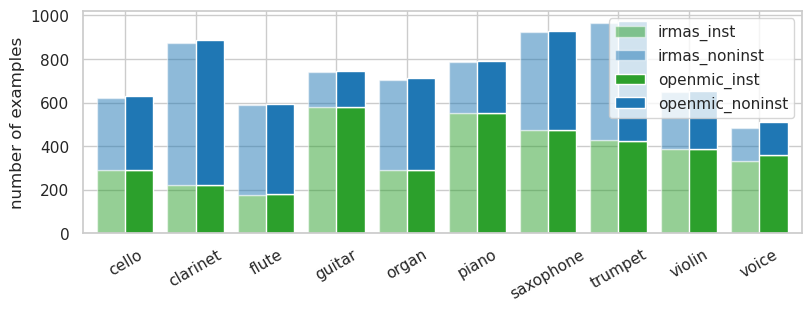

In [27]:
sns.set_theme(context='notebook', style='whitegrid')
plt.rcParams['figure.constrained_layout.use'] = True
df = pd.DataFrame({'instrument': class_list, 
                    'openmic_inst': openmic_inst,
                    'openmic_noninst': openmic_noninst,
                    'irmas_inst': irmas_inst,
                    'irmas_noninst': irmas_noninst})

fig, ax = plt.subplots(figsize=(8,3))
# colors = ['#0271AE', '#DC2830']
colors = ['tab:green', 'tab:blue']
# colors = ['green', 'blue', 'tab:green', 'tab:blue']
df.plot(stacked=True, kind='bar', x='instrument', y=['irmas_inst','irmas_noninst'], ax=ax, position=1, width=0.4, color=colors, alpha=.5)
df.plot(stacked=True, kind='bar', x='instrument', y=['openmic_inst','openmic_noninst'], ax=ax, position=0, width=0.4, color=colors)
plt.xlim([-.6, len(df) - .4])
plt.xticks(rotation=30)
plt.xlabel('')
plt.ylabel('number of examples')
plt.savefig('results/train_set_distribution.pdf', bbox_inches='tight')

In [28]:
with open("genre_map.json", "r") as f: # only consider 10 classes of Openmic dataset
    genre_map = json.load(f)

In [29]:
genre_info = pd.DataFrame(columns=['instrument', 'genre', 'examples', 'train_set'])

for inst in class_list:
    inst_genre_num = []
    for genre in list(genre_map):
        inst_genre_num.append(len(irmas_inst_genre[inst][irmas_inst_genre[inst] == genre]))

    genre_inst = pd.DataFrame(columns=['instrument', 'genre', 'examples', 'train_set'])
    genre_inst['instrument'] = [inst] * len(list(genre_map))
    genre_inst['genre'] = list(genre_map)
    genre_inst['examples'] = inst_genre_num
    genre_inst['train_set'] = ['irmas'] * len(list(genre_map))

    genre_info = genre_info.append(genre_inst)
    
for inst in class_list:
    inst_genre_num = []
    for genre in list(genre_map):
        inst_genre_num.append(len(openmic_inst_genre[inst][openmic_inst_genre[inst] == genre]))

    genre_inst = pd.DataFrame(columns=['instrument', 'genre', 'examples', 'train_set'])
    genre_inst['instrument'] = [inst] * len(list(genre_map))
    genre_inst['genre'] = list(genre_map)
    genre_inst['examples'] = inst_genre_num
    genre_inst['train_set'] = ['openmic'] * len(list(genre_map))

    genre_info = genre_info.append(genre_inst)

In [30]:
genre_info[:10]

,instrument,genre,examples,train_set
0,cello,pop_rock,82,irmas
1,cello,jazz_blue,22,irmas
2,cello,classical,184,irmas
3,cello,country_folk,0,irmas
0,clarinet,pop_rock,58,irmas
1,clarinet,jazz_blue,61,irmas
2,clarinet,classical,102,irmas
3,clarinet,country_folk,0,irmas
0,flute,pop_rock,56,irmas
1,flute,jazz_blue,51,irmas


In [31]:
openmic_perinst = []
for instrument in class_list:
    openmic_perinst.append(list(genre_info.loc[(genre_info['train_set'] == 'openmic') & (genre_info['instrument'] == instrument)]['examples']))

openmic_perinst = np.array(openmic_perinst)
np.transpose(openmic_perinst)[:-1,:].sum(0)

array([252, 199, 148, 339, 279, 499, 431, 379, 281, 271])

In [32]:
irmas_perinst = []
for instrument in class_list:
    irmas_perinst.append(list(genre_info.loc[(genre_info['train_set'] == 'irmas') & (genre_info['instrument'] == instrument)]['examples']))

irmas_perinst = np.array(irmas_perinst)
np.transpose(irmas_perinst)[:-1,:].sum(0)

array([288, 221, 166, 519, 289, 542, 473, 427, 360, 216])

In [33]:
openmic_inst = []; irmas_inst = []
for inst in class_list:
    openmic_inst.append(genre_info.loc[(genre_info['instrument'] == inst) & (genre_info['train_set'] == 'openmic')]['examples'].sum())
    irmas_inst.append(genre_info.loc[(genre_info['instrument'] == inst) & (genre_info['train_set'] == 'irmas')]['examples'].sum())
print(class_list)
print(openmic_inst)
print(irmas_inst)

['cello', 'clarinet', 'flute', 'guitar', 'organ', 'piano', 'saxophone', 'trumpet', 'violin', 'voice']
[290, 223, 179, 580, 292, 551, 475, 425, 387, 360]
[288, 221, 177, 578, 290, 551, 476, 427, 385, 333]


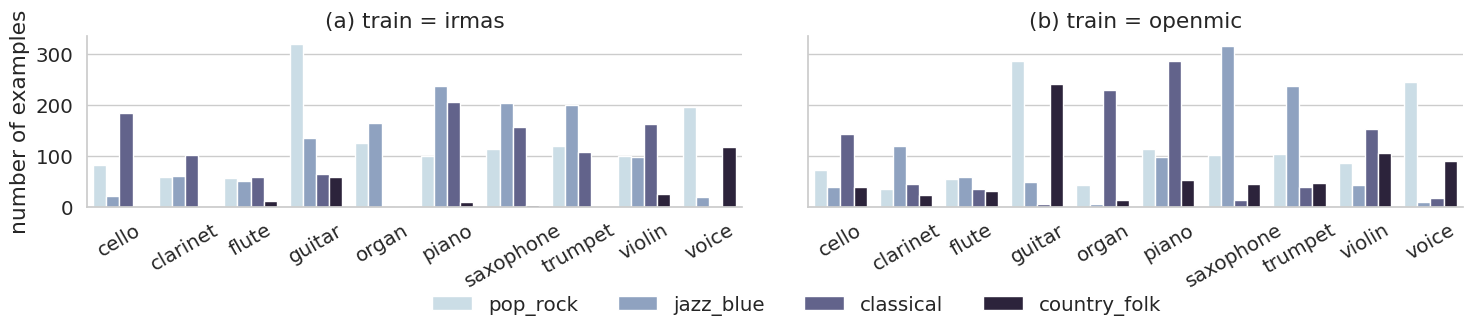

In [34]:
# save cosine similarity into a csv file
sns.set_theme(context='notebook', style='whitegrid', font_scale=1.3)

ax = sns.catplot(data=genre_info, col='train_set', x='instrument', y='examples', hue='genre', kind='bar', height=3, aspect=2.5,
               legend_out=False, palette="ch:s=.25,rot=-.25")

a0 = ax.fig.axes[0]
a0.set_title("(a) train = irmas")
# a0.set_ylim([0,400])
a1 = ax.fig.axes[1]
a1.set_title("(b) train = openmic")
# a1.set_ylim([0,400])

ax.set(ylabel='number of examples')
ax.set(xlabel=None)
lgd = sns.move_legend(ax, "lower center", bbox_to_anchor=(.54, -.15), ncol=5, title=None, frameon=False)
plt.subplots_adjust(wspace=0.1)
ax.set_xticklabels(rotation=30)
# plt.title('Genre information per instrument')
plt.savefig('results/genre_information.pdf', bbox_inches='tight')

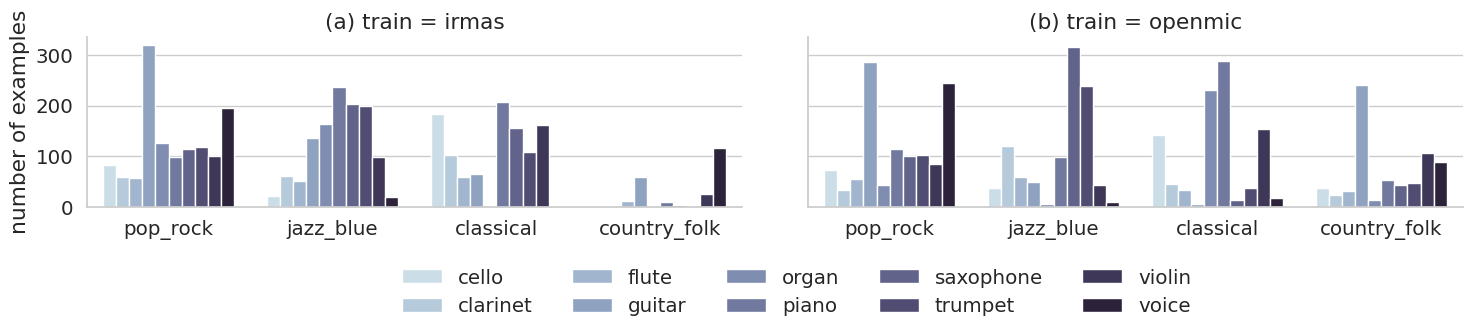

In [45]:
# save cosine similarity into a csv file
sns.set_theme(context='notebook', style='whitegrid', font_scale=1.3)

ax = sns.catplot(data=genre_info, col='train_set', x='genre', y='examples', hue='instrument', kind='bar', height=3, aspect=2.5,
               legend_out=False, palette="ch:s=.25,rot=-.25")

a0 = ax.fig.axes[0]
a0.set_title("(a) train = irmas")
# a0.set_ylim([0,400])
a1 = ax.fig.axes[1]
a1.set_title("(b) train = openmic")
# a1.set_ylim([0,400])

ax.set(ylabel='number of examples')
ax.set(xlabel=None)
lgd = sns.move_legend(ax, "lower center", bbox_to_anchor=(.54, -.15), ncol=5, title=None, frameon=False)
plt.subplots_adjust(wspace=0.1)
# ax.set_xticklabels(rotation=30)
# plt.title('Genre information per instrument')
plt.savefig('results/genre_information_instrument.pdf', bbox_inches='tight')

## A-distance: original

In [36]:
from proxy_A_distance import proxy_a_distance

In [37]:
proxy_a_distance(X_train_irmas, X_train_openmic, verbose=False)

0.8247179659875399

In [38]:
proxy_a_distance(X_train_openmic, X_train_irmas, verbose=False)

0.8247179659875399

In [39]:
# check data amount
openmic_inst = []
openmic_noninst = []
openmic_inst_genre = {inst:[] for inst in instrument_map}
irmas_inst = []
irmas_noninst = []
irmas_inst_genre = {inst:[] for inst in instrument_map}

Adiance_inst = []
Adiance_inst_true = []

for inst in instrument_map:
    ###### openmic ######
    # Map the instrument name to its column number
    inst_num = class_map[inst]
    train_inst = Y_mask_train[:, inst_num]
    
    genre_train_inst_openmic = genre_train_openmic[train_inst]
    X_train_inst_openmic = X_train_openmic[train_inst]
    Y_train_inst_openmic = Y_train_openmic[train_inst, inst_num] >= 0.5
    Y_train_noninst_openmic = Y_train_openmic[train_inst, inst_num] < 0.5
    
    ###### irmas ######
    X_train_inst_irmas = X_train_irmas
    genre_train_inst_irmas = genre_train_irmas

    # get the training and testing labels for each instrument
    Y_train_inst_irmas = Y_train_irmas==inst
    Y_train_noninst_irmas = Y_train_irmas!=inst

    ###### classification ######
    X_train_inst_openmic_true = X_train_inst_openmic[Y_train_inst_openmic]
    X_train_inst_openmic_false = X_train_inst_openmic[Y_train_noninst_openmic]

    X_train_inst_irmas_true = X_train_inst_irmas[Y_train_inst_irmas]
    X_train_inst_irmas_false = X_train_inst_irmas[Y_train_noninst_irmas]

    genre_train_inst_openmic_true = genre_train_inst_openmic[Y_train_inst_openmic]
    genre_train_inst_openmic_false = genre_train_inst_openmic[Y_train_noninst_openmic]

    genre_train_inst_irmas_true = genre_train_inst_irmas[Y_train_inst_irmas]
    genre_train_inst_irmas_false = genre_train_inst_irmas[Y_train_noninst_irmas]

    dim_inst = min(X_train_inst_openmic_true.shape[0], X_train_inst_irmas_true.shape[0])
    dim_noninst = min(X_train_inst_openmic_false.shape[0], X_train_inst_irmas_false.shape[0])

    X_train_inst_openmic_true, genre_train_inst_openmic_true = deb.resample_data(X_train_inst_openmic_true, genre_train_inst_openmic_true, dim_inst)
    X_train_inst_irmas_true, genre_train_inst_irmas_true = deb.resample_data(X_train_inst_irmas_true, genre_train_inst_irmas_true, dim_inst)

    X_train_inst_openmic_false, genre_train_inst_openmic_false = deb.resample_data(X_train_inst_openmic_false, genre_train_inst_openmic_false, dim_noninst)
    X_train_inst_irmas_false, genre_train_inst_irmas_false = deb.resample_data(X_train_inst_irmas_false, genre_train_inst_irmas_false, dim_noninst)

    X_train_inst_openmic = np.vstack((X_train_inst_openmic_true, X_train_inst_openmic_false))
    X_train_inst_irmas = np.vstack((X_train_inst_irmas_true, X_train_inst_irmas_false))

    Adiance_inst.append(proxy_a_distance(X_train_inst_irmas, X_train_inst_openmic, verbose=False))
    Adiance_inst_true.append(proxy_a_distance(X_train_inst_irmas_true, X_train_inst_openmic_true, verbose=False))

In [40]:
Adiance_inst

[0.8992,
 0.9681818181818183,
 1.1418918918918919,
 0.9232839838492597,
 0.6723163841807909,
 0.2987341772151899,
 0.7589189189189189,
 0.9237113402061856,
 0.3410138248847927,
 0.8088531187122736]

In [41]:
Adiance_inst  # after LDA

[0.8992,
 0.9681818181818183,
 1.1418918918918919,
 0.9232839838492597,
 0.6723163841807909,
 0.2987341772151899,
 0.7589189189189189,
 0.9237113402061856,
 0.3410138248847927,
 0.8088531187122736]

In [42]:
Adiance_inst_true

[1.1418685121107266,
 0.24215246636771304,
 0.6592178770949721,
 0.9015544041450778,
 1.8900343642611683,
 0.644927536231884,
 0.6386554621848739,
 0.9039812646370022,
 0.43927648578811374,
 1.4121037463976944]

In [43]:
Adiance_inst_true # after LDA

[1.1418685121107266,
 0.24215246636771304,
 0.6592178770949721,
 0.9015544041450778,
 1.8900343642611683,
 0.644927536231884,
 0.6386554621848739,
 0.9039812646370022,
 0.43927648578811374,
 1.4121037463976944]

## A-distance: after LDA

In [44]:
# check data amount
openmic_inst = []
openmic_noninst = []
openmic_inst_genre = {inst:[] for inst in instrument_map}
irmas_inst = []
irmas_noninst = []
irmas_inst_genre = {inst:[] for inst in instrument_map}

Adiance_inst = []
Adiance_inst_true = []

for inst in instrument_map:
    ###### openmic ######
    # Map the instrument name to its column number
    inst_num = class_map[inst]
    train_inst = Y_mask_train[:, inst_num]
    
    genre_train_inst_openmic = genre_train_openmic[train_inst]
    X_train_inst_openmic = X_train_openmic[train_inst]
    Y_train_inst_openmic = Y_train_openmic[train_inst, inst_num] >= 0.5
    Y_train_noninst_openmic = Y_train_openmic[train_inst, inst_num] < 0.5
    
    ###### irmas ######
    X_train_inst_irmas = X_train_irmas
    genre_train_inst_irmas = genre_train_irmas

    # get the training and testing labels for each instrument
    Y_train_inst_irmas = Y_train_irmas==inst
    Y_train_noninst_irmas = Y_train_irmas!=inst

    ###### classification ######
    X_train_inst_openmic_true = X_train_inst_openmic[Y_train_inst_openmic]
    X_train_inst_openmic_false = X_train_inst_openmic[Y_train_noninst_openmic]

    X_train_inst_irmas_true = X_train_inst_irmas[Y_train_inst_irmas]
    X_train_inst_irmas_false = X_train_inst_irmas[Y_train_noninst_irmas]

    genre_train_inst_openmic_true = genre_train_inst_openmic[Y_train_inst_openmic]
    genre_train_inst_openmic_false = genre_train_inst_openmic[Y_train_noninst_openmic]

    genre_train_inst_irmas_true = genre_train_inst_irmas[Y_train_inst_irmas]
    genre_train_inst_irmas_false = genre_train_inst_irmas[Y_train_noninst_irmas]

    dim_inst = min(X_train_inst_openmic_true.shape[0], X_train_inst_irmas_true.shape[0])
    dim_noninst = min(X_train_inst_openmic_false.shape[0], X_train_inst_irmas_false.shape[0])

    X_train_inst_openmic_true, genre_train_inst_openmic_true = deb.resample_data(X_train_inst_openmic_true, genre_train_inst_openmic_true, dim_inst)
    X_train_inst_irmas_true, genre_train_inst_irmas_true = deb.resample_data(X_train_inst_irmas_true, genre_train_inst_irmas_true, dim_inst)

    X_train_inst_openmic_false, genre_train_inst_openmic_false = deb.resample_data(X_train_inst_openmic_false, genre_train_inst_openmic_false, dim_noninst)
    X_train_inst_irmas_false, genre_train_inst_irmas_false = deb.resample_data(X_train_inst_irmas_false, genre_train_inst_irmas_false, dim_noninst)

    X_train_inst_openmic = np.vstack((X_train_inst_openmic_true, X_train_inst_openmic_false))
    X_train_inst_irmas = np.vstack((X_train_inst_irmas_true, X_train_inst_irmas_false))

    ############### LDA ###############
    # project the separation direction of the instrument class
    X_train_conca = np.vstack((X_train_inst_irmas_true, X_train_inst_openmic_true))
    Y_A = np.zeros(len(X_train_inst_irmas_true))
    Y_B = np.ones(len(X_train_inst_openmic_true))
    Y_conca = np.hstack((Y_A, Y_B))

    LDA = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto')
    LDA.fit(X_train_conca, Y_conca)

    v = LDA.coef_.copy()
    v /= np.sqrt(np.sum(v**2))
    A = np.outer(v, v)

    X_train_inst_irmas = X_train_inst_irmas.copy().dot(np.eye(len(A)) - A)
    X_train_inst_openmic = X_train_inst_openmic.copy().dot(np.eye(len(A)) - A)
    X_train_inst_irmas_true = X_train_inst_irmas_true.copy().dot(np.eye(len(A)) - A)
    X_train_inst_openmic_true = X_train_inst_openmic_true.copy().dot(np.eye(len(A)) - A)

    Adiance_inst.append(proxy_a_distance(X_train_inst_irmas, X_train_inst_openmic, verbose=False))
    Adiance_inst_true.append(proxy_a_distance(X_train_inst_irmas_true, X_train_inst_openmic_true, verbose=False))

KeyboardInterrupt: 